# Tutorial 1: scattering transform

Authors: René Steinmann and Léonard Seydoux

Date: January 16, 2023

Welcome to this tutorial on transforming seismic data into scattering coefficients using a scattering network. In this Jupyter notebook, we will walk through the process of using the scattering network to extract useful features from seismic data. This technique has been proven to be efficient for clustering various types of seismic signals from continuous seismic data. We will begin by introducing the basic concepts of scattering networks and then move on to implementing the technique using Python and the ScatSeisNet library.

In [1]:
import pandas as pd
import numpy as np
import obspy 
import pickle
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime

from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scatseisnet import ScatteringNetwork, signal

In [2]:
#%load_ext autoreload
#%autoreload 2
#%config InlineBackend.figure_formats = ['svg']

## Load seismic data

This case serves as a basic example of how the scattering network can be applied to various data sets. The example data used in this case is a small subset of the data from the [IRIS data center](https://ds.iris.edu/ds/nodes/dmc/), specifically two hours of three-component data from our study Steinmann et al. ([2022](https://doi.org/10.1029/2021JB022455)). Note that this can be easily adapted to handle larger and more complex data sets by simply adjusting the input parameters and increasing the computational resources.

In [3]:
def load_data(show=True):
    """Users: manage.
    
    Give traces as a numpy array.
    times : (n_times, )
    data: (n_channels, n_times)
    """
    
    client = Client("IRIS")
    
    stream = client.get_waveforms(network="YH",station='DC06',location='*',channel='*',starttime=UTCDateTime("2012-07-25T00:00"),endtime=UTCDateTime("2012-07-27T00:00"))
    stream.detrend("linear")
    stream.merge(method=1)
    stream.detrend("linear")
    stream.filter(type="highpass", freq=1)
    
    if show == True:
        stream.plot()
    
    # Numpyification
    times = stream[0].times("matplotlib")
    data = np.array([trace.data for trace in stream])
        
    return times, data

/home/steinmar/anaconda3/envs/ssn_api/lib/python3.10/site-packages/obspy-1.4.0-py3.10-linux-x86_64.egg/obspy/imaging/waveform.py:804: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  self.fig.subplots_adjust(hspace=0)
/home/steinmar/anaconda3/envs/ssn_api/lib/python3.10/site-packages/obspy-1.4.0-py3.10-linux-x86_64.egg/obspy/imaging/waveform.py:289: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  self.fig.subplots_adjust(top=1.0 - fract_y, bottom=fract_y2,


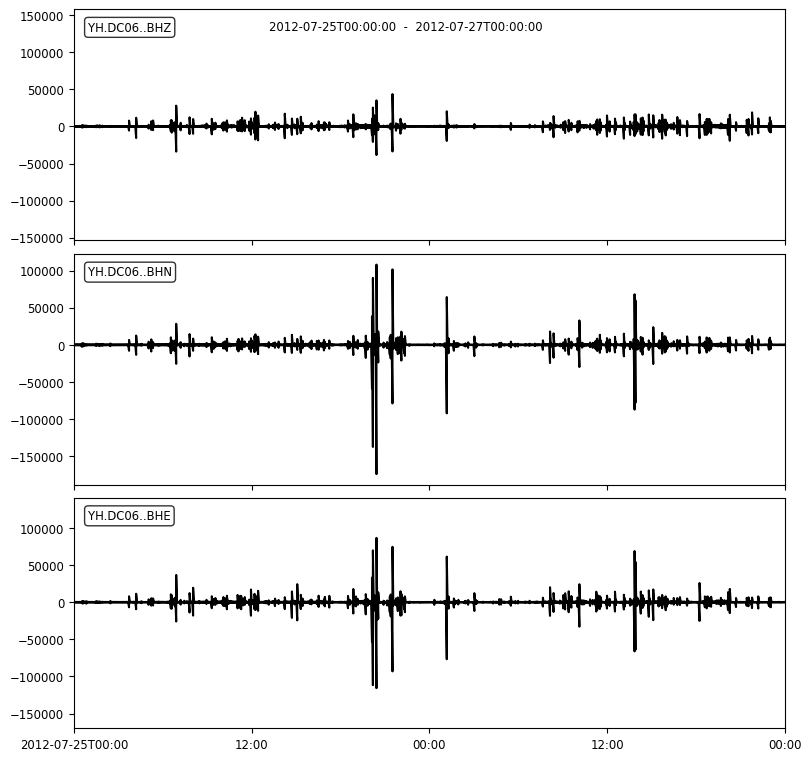

In [12]:
# Extract stream
times, data = load_data(show=True)

## Meta parameters

The following cell defines the meta parameter of the network:

- `SEGMENT` represents the window size used to chunk the data into pieces before passing it to the scattering network. We define it here in seconds since we know the data sampling rate.
-`STEP` defines the sliding duration between two consecutive windows.
- `OCTAVES` indicates the number of octaves per layer. This value can be a tuple where the number of elements defines the number of layers. 
- `RESOLUTION` represents the number of wavelets per octave (must be of the size of `OCTAVES`)
- `QUALITY` represents the quality factor of the mother wavelet (must be of the size of `OCTAVES`)
- `SAMPLING_RATE` and other values allow turning the window and stepping durations into samples. If the sampling rate is unknown, it can be turned to a reduced frequency (1) or angular frequency (2$\pi$).

Note that the type of pooling operation will be set later and not in this cell. It is not part of the network initiation.

In [17]:
SEGMENT = 20
STEP = 10
SAMPLING_RATE = 50
SAMPLES_PER_SEGMENT = int(SEGMENT * SAMPLING_RATE)
SAMPLES_PER_STEP = int(STEP * SAMPLING_RATE)
BANKS = (
    {"octaves": 3, "resolution": 4, "quality": 1},
    {"octaves": 5, "resolution": 1, "quality": 3}
)

## Network definition

We instantiate the network from the meta parameters defined in the previous cell. The following cell allows defining the scattering network graph but does not compile it. The compilation stage occurs at the first use of the network.

In [18]:
net = ScatteringNetwork(
    BANKS, bins=SAMPLES_PER_SEGMENT, sampling_rate=SAMPLING_RATE
)

## Show the filter banks

We can easily access the different properties of the network and visualize the filter banks, for instance. Note that if the notebook implements the CPU version, there is no need to transfer the data to the CPU device with the `get` method.

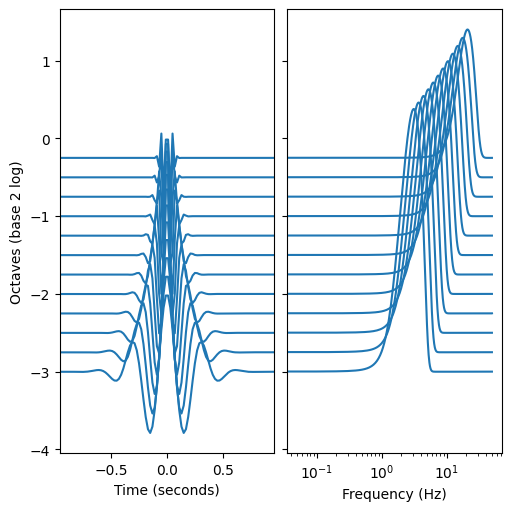

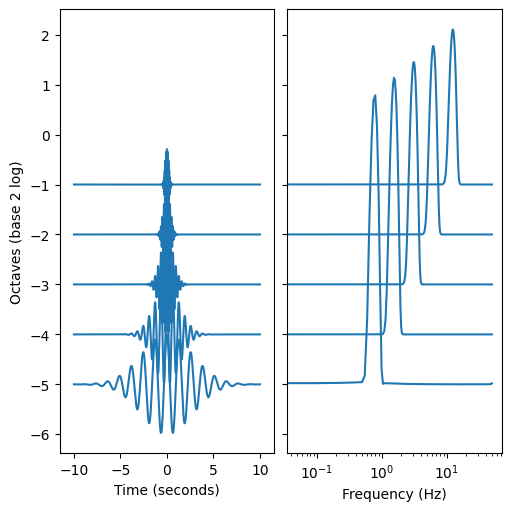

In [19]:
# Loop over network layers
for bank in net.banks:
    
    # Crete axes
    fig, ax = plt.subplots(1, 2, sharey=True)

    # Show each wavelet
    iterable = zip(bank.wavelets, bank.spectra, bank.ratios)
    for wavelet, spectrum, ratio in iterable:
        
        # Time domain
        ax[0].plot(bank.times, wavelet.real + ratio, "C0")
    
        # Spectral domain
        ax[1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, "C0")

    # Limit view to three times the temporal width of largest wavelet
    width_max = 3 * bank.widths.max()
    
    # Labels
    ax[0].set_ylabel("Octaves (base 2 log)")
    ax[0].set_xlabel("Time (seconds)")
    ax[0].set_xlim(-width_max, width_max)
    ax[1].set_xscale("log")
    ax[1].set_xlabel("Frequency (Hz)")

## The main part: calculating the scattering coefficients

After loading some example data and initiating the scattering network, we can now caclulate the scattering coefficients. Firstly, we segmentize the continuous stream and feed these segements into the scattering network. Here we also set what kind of `POOLING` we want to use (so far we implemented maximum `max` and average pooling`avg`). Later, the scattering coefficients should be saved with `pickle`(or any other preferred serializer) in order to be used later.

In [20]:
POOLING = "max"

# Segmentization
data_segments = signal.segmentize(data, SAMPLES_PER_SEGMENT, SAMPLES_PER_STEP)
times_scat = signal.segmentize(times, SAMPLES_PER_SEGMENT, SAMPLES_PER_STEP)[:, 0]

# Scattering transform
scattering_coefficients = net.transform(data_segments, POOLING)


## Show some output

In the following example one can observe the scattering coefficients.

Text(0, 0.5, 'Frequency (Hz)')

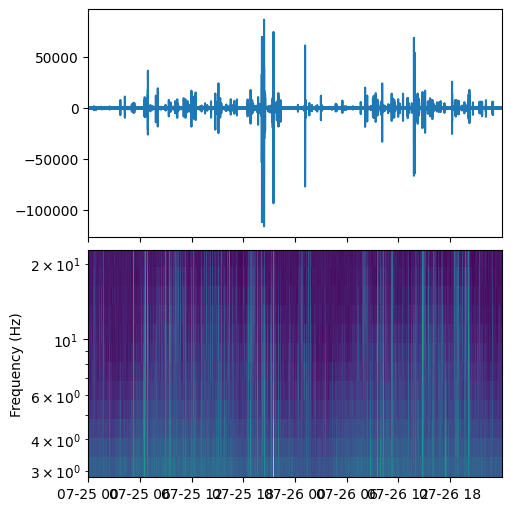

In [21]:
CHANNEL = 0

fig, ax = plt.subplots(2, sharex=True)

frequencies = net.banks[0].centers
timestamps = pd.to_datetime(times, unit="D")
timestamps_scats = pd.to_datetime(times_scat, unit="D")

first_order_scattering_coefficients = np.squeeze(scattering_coefficients[0][:, CHANNEL, :].T)
first_order_scattering_coefficients = np.log(first_order_scattering_coefficients)

ax[0].plot(timestamps, data[CHANNEL], rasterized=True)

ax[1].pcolormesh(times_scat, frequencies, first_order_scattering_coefficients, rasterized=True)
ax[1].set_yscale("log")
ax[1].set_ylabel("Frequency (Hz)")

## Save the output
Until now, we applied the scattering network to the 3C seismic data. In the other tutorial, we apply FastICA to the scattering coefficients in order to extract the most relevant features. Therefore, we save the first and second-order scattering coefficients as a npz-file and the scattering network as a pickle.

In [23]:
# SAVE SCATTERING COEFFICIENTS IN NPZ FILE

np.savez('example/scatnet_output.npz',
    scat_coef_0=scattering_coefficients[0],
    scat_coef_1 = scattering_coefficients[1],
    times = times_scat
)

In [24]:
# SAVE NETWORK IN PICKLE FILE

with open('example/network.pickle', 'wb') as handle:
    pickle.dump(net, handle, protocol=pickle.HIGHEST_PROTOCOL)